In [56]:
import os
import sys
import math
import heapq
import matplotlib.pyplot as plt


In [57]:
class Env:
    def __init__(self):
        self.x_range = 51  # size of background
        self.y_range = 31
        self.motions = [(-1, 0), (-1, 1), (0, 1), (1, 1),
                        (1, 0), (1, -1), (0, -1), (-1, -1)]
        self.obs = self.obs_map()

    def update_obs(self, obs):  # 用于替换为自定义环境
        self.obs = obs

    def obs_map(self):
        """
        Initialize obstacles' positions
        :return: map of obstacles 包含障碍物信息的集合
        """

        x = self.x_range
        y = self.y_range
        obs = set()

        for i in range(x):  # 上下两条边界
            obs.add((i, 0))
        for i in range(x):
            obs.add((i, y - 1))

        for i in range(y):  # 左右两条边界
            obs.add((0, i))
        for i in range(y):
            obs.add((x - 1, i))

        for i in range(10, 21):
            obs.add((i, 15))
        for i in range(15):
            obs.add((20, i))

        for i in range(15, 30):
            obs.add((30, i))
        for i in range(16):
            obs.add((40, i))

        return obs

In [58]:
class Plotting:
    def __init__(self, xI, xG):
        self.xI, self.xG = xI, xG   # 起点 和 终点 坐标
        self.env = Env()
        self.obs = self.env.obs_map()

    def update_obs(self, obs):
        self.obs = obs

    def animation(self, path, visited, name):
        self.plot_grid(name)
        self.plot_visited(visited)
        self.plot_path(path)
        #plt.show()

    def animation_lrta(self, path, visited, name):
        self.plot_grid(name)
        cl = self.color_list_2()
        path_combine = []

        for k in range(len(path)):
            self.plot_visited(visited[k], cl[k])
            plt.pause(0.2)
            self.plot_path(path[k])
            path_combine += path[k]
            plt.pause(0.2)
        if self.xI in path_combine:
            path_combine.remove(self.xI)
        self.plot_path(path_combine)
        plt.show()

    def animation_ara_star(self, path, visited, name):
        self.plot_grid(name)
        cl_v, cl_p = self.color_list()

        for k in range(len(path)):
            self.plot_visited(visited[k], cl_v[k])
            self.plot_path(path[k], cl_p[k], True)
            plt.pause(0.5)

        plt.show()

    def animation_bi_astar(self, path, v_fore, v_back, name):
        self.plot_grid(name)
        self.plot_visited_bi(v_fore, v_back)
        self.plot_path(path)
        plt.show()

    def plot_grid(self, name):
        obs_x = [x[0] for x in self.obs]
        obs_y = [x[1] for x in self.obs]

        plt.plot(self.xI[0], self.xI[1], "bs")  # 起点 - 蓝色
        plt.plot(self.xG[0], self.xG[1], "gs")  # 终点 - 绿色
        plt.plot(obs_x, obs_y, "sk")
        plt.title(name)
        plt.axis("equal")
        

    def plot_visited(self, visited, cl='gray'):
        if self.xI in visited:
            visited.remove(self.xI)

        if self.xG in visited:
            visited.remove(self.xG)

        count = 0

        for x in visited:
            count += 1
            plt.plot(x[0], x[1], color=cl, marker='o')
            plt.gcf().canvas.mpl_connect('key_release_event',
                                         lambda event: [exit(0) if event.key == 'escape' else None])

            if count < len(visited) / 3:
                length = 20
            elif count < len(visited) * 2 / 3:
                length = 30
            else:
                length = 40

            # if count % length == 0:
                # plt.pause(0.001)
        # plt.pause(0.01)

    def plot_path(self, path, cl='r', flag=False):
        path_x = [path[i][0] for i in range(len(path))]
        path_y = [path[i][1] for i in range(len(path))]

        if not flag:
            plt.plot(path_x, path_y, linewidth='3', color='r')
        else:
            plt.plot(path_x, path_y, linewidth='3', color=cl)

        plt.plot(self.xI[0], self.xI[1], "bs")
        plt.plot(self.xG[0], self.xG[1], "gs")

        plt.pause(0.01)

    def plot_visited_bi(self, v_fore, v_back):
        if self.xI in v_fore:
            v_fore.remove(self.xI)

        if self.xG in v_back:
            v_back.remove(self.xG)

        len_fore, len_back = len(v_fore), len(v_back)

        for k in range(max(len_fore, len_back)):
            if k < len_fore:
                plt.plot(v_fore[k][0], v_fore[k][1], linewidth='3', color='gray', marker='o')
            if k < len_back:
                plt.plot(v_back[k][0], v_back[k][1], linewidth='3', color='cornflowerblue', marker='o')

            plt.gcf().canvas.mpl_connect('key_release_event',
                                         lambda event: [exit(0) if event.key == 'escape' else None])

            if k % 10 == 0:
                plt.pause(0.001)
        plt.pause(0.01)

    @staticmethod
    def color_list():
        cl_v = ['silver',
                'wheat',
                'lightskyblue',
                'royalblue',
                'slategray']
        cl_p = ['gray',
                'orange',
                'deepskyblue',
                'red',
                'm']
        return cl_v, cl_p

    @staticmethod
    def color_list_2():
        cl = ['silver',
              'steelblue',
              'dimgray',
              'cornflowerblue',
              'dodgerblue',
              'royalblue',
              'plum',
              'mediumslateblue',
              'mediumpurple',
              'blueviolet',
              ]
        return cl

In [59]:
class AStar:
    """AStar set the cost + heuristics as the priority
    """
    def __init__(self, s_start, s_goal, heuristic_type):
        self.s_start = s_start
        self.s_goal = s_goal
        self.heuristic_type = heuristic_type

        self.Env = Env()  # 生成环境

        self.u_set = self.Env.motions  # feasible input set 用于搜索当前节点的邻居
        self.obs = self.Env.obs  # position of obstacles 包含障碍物位置信息的集合

        self.OPEN = []  # priority queue / OPEN set 已被检测到的节点
        self.CLOSED = []  # CLOSED set / VISITED order  已访问节点(已找到到源点的最短路径)
        self.PARENT = dict()  # recorded parent
        self.g = dict()  # cost to come 记录节点到源点的最短距离

    def searching(self):
        """
        A_star Searching.
        :return: path, visited order
        """

        self.PARENT[self.s_start] = self.s_start
        self.g[self.s_start] = 0
        self.g[self.s_goal] = math.inf
        heapq.heappush(self.OPEN,
                       (self.f_value(self.s_start), self.s_start))

        while self.OPEN:
            _, s = heapq.heappop(self.OPEN)
            self.CLOSED.append(s)

            if s == self.s_goal:  # stop condition
                break

            for s_n in self.get_neighbor(s):
                new_cost = self.g[s] + self.cost(s, s_n)

                if s_n not in self.g:
                    self.g[s_n] = math.inf

                if new_cost < self.g[s_n]:  # conditions for updating Cost
                    self.g[s_n] = new_cost
                    self.PARENT[s_n] = s
                    heapq.heappush(self.OPEN, (self.f_value(s_n), s_n))

        return self.extract_path(self.PARENT), self.CLOSED

    def searching_repeated_astar(self, e):
        """
        repeated A*.
        :param e: weight of A*
        :return: path and visited order
        """

        path, visited = [], []

        while e >= 1:
            p_k, v_k = self.repeated_searching(self.s_start, self.s_goal, e)
            path.append(p_k)
            visited.append(v_k)
            e -= 0.5

        return path, visited

    def repeated_searching(self, s_start, s_goal, e):
        """
        run A* with weight e.
        :param s_start: starting state
        :param s_goal: goal state
        :param e: weight of a*
        :return: path and visited order.
        """

        g = {s_start: 0, s_goal: float("inf")}
        PARENT = {s_start: s_start}
        OPEN = []
        CLOSED = []
        heapq.heappush(OPEN,
                       (g[s_start] + e * self.heuristic(s_start), s_start))

        while OPEN:
            _, s = heapq.heappop(OPEN)
            CLOSED.append(s)

            if s == s_goal:
                break

            for s_n in self.get_neighbor(s):
                new_cost = g[s] + self.cost(s, s_n)

                if s_n not in g:
                    g[s_n] = math.inf

                if new_cost < g[s_n]:  # conditions for updating Cost
                    g[s_n] = new_cost
                    PARENT[s_n] = s
                    heapq.heappush(OPEN, (g[s_n] + e * self.heuristic(s_n), s_n))

        return self.extract_path(PARENT), CLOSED

    def get_neighbor(self, s):
        """
        find neighbors of state s that not in obstacles.
        :param s: state
        :return: neighbors
        """

        return [(s[0] + u[0], s[1] + u[1]) for u in self.u_set]

    def cost(self, s_start, s_goal):
        """
        Calculate Cost for this motion
        :param s_start: starting node
        :param s_goal: end node
        :return:  Cost for this motion
        :note: Cost function could be more complicate!
        """

        if self.is_collision(s_start, s_goal):
            return math.inf

        return math.hypot(s_goal[0] - s_start[0], s_goal[1] - s_start[1])

    def is_collision(self, s_start, s_end):
        """
        check if the line segment (s_start, s_end) is collision.
        :param s_start: start node
        :param s_end: end node
        :return: True: is collision / False: not collision
        """

        if s_start in self.obs or s_end in self.obs:
            return True

        if s_start[0] != s_end[0] and s_start[1] != s_end[1]:
            if s_end[0] - s_start[0] == s_start[1] - s_end[1]:
                s1 = (min(s_start[0], s_end[0]), min(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
            else:
                s1 = (min(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), min(s_start[1], s_end[1]))

            if s1 in self.obs or s2 in self.obs:
                return True

        return False

    def f_value(self, s):
        """
        f = g + h. (g: Cost to come, h: heuristic value)
        :param s: current state
        :return: f
        """

        return self.g[s] + self.heuristic(s)

    def extract_path(self, PARENT):
        """
        Extract the path based on the PARENT set.
        :return: The planning path
        """

        path = [self.s_goal]
        s = self.s_goal

        while True:
            s = PARENT[s]
            path.append(s)

            if s == self.s_start:
                break

        return list(path)

    def heuristic(self, s):
        """
        Calculate heuristic.
        :param s: current node (state)
        :return: heuristic function value
        """

        heuristic_type = self.heuristic_type  # heuristic type
        goal = self.s_goal  # goal node

        if heuristic_type == "manhattan":
            return abs(goal[0] - s[0]) + abs(goal[1] - s[1])
        else:
            return math.hypot(goal[0] - s[0], goal[1] - s[1])


In [60]:
class Dijkstra(AStar):
    """Dijkstra set the cost as the priority 
    """
    def searching(self):
        """
        Breadth-first Searching.
        :return: path, visited order
        """

        self.PARENT[self.s_start] = self.s_start
        self.g[self.s_start] = 0
        self.g[self.s_goal] = math.inf
        heapq.heappush(self.OPEN,
                       (0, self.s_start))

        while self.OPEN:
            _, s = heapq.heappop(self.OPEN)
            self.CLOSED.append(s)

            if s == self.s_goal:
                break

            for s_n in self.get_neighbor(s):
                new_cost = self.g[s] + self.cost(s, s_n)

                if s_n not in self.g:
                    self.g[s_n] = math.inf

                if new_cost < self.g[s_n]:  # conditions for updating Cost
                    self.g[s_n] = new_cost
                    self.PARENT[s_n] = s

                    # best first set the heuristics as the priority 
                    heapq.heappush(self.OPEN, (new_cost, s_n))

        return self.extract_path(self.PARENT), self.CLOSED  # 返回起点到终点的路径 以及 所有已访问节点(按加入顺序排列)

In [61]:
s_start = (5, 5)
s_goal = (45, 25)

dijkstra = Dijkstra(s_start, s_goal, 'None')
plot = Plotting(s_start, s_goal)

path, visited = dijkstra.searching()


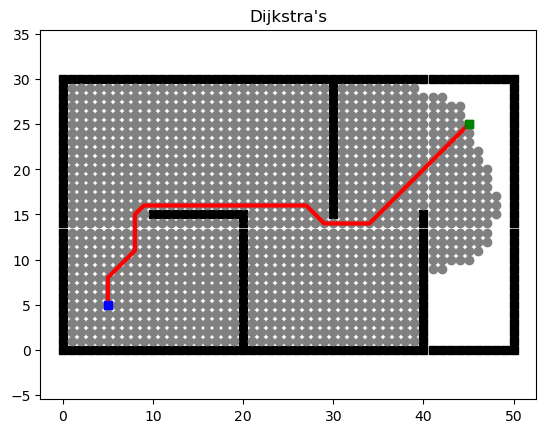

In [62]:
plot.animation(path, visited, "Dijkstra's")  # animation generate